# **Mini Lab: Logistic Regression & Support Vector Machines**

**Group 2 Members:**
Reagan Meagher, Jaclyn Coate, Megan Riley, and Matthew Chinchilla

**Kaggle Link To Data:** https://www.kaggle.com/muonneutrino/us-census-demographic-data

**Logits & SVM Github Link:** https://github.com/jakemdrew/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb

##**1. Logistic Regression & Support Vector Machine Model Building**


In this section we will read in and set up the data, create train and test splits for our models, create a logistic regression model, and create a support vector machine model.

### **1.1 Data Read In & Set Up**



The data we used for this lab is the same as Lab 1. It is a 2015 United States census data set for the all 50 states at the census tract level, accessed via Kaggle. This data set contains demographic data about each census tract such as ethnicity, job function, commute types, poverty, income, and unemployment. 

This Mini Lab is a classification predictive analysis so we need to create our categorical Poverty Class attribute off of the continuous Poverty percentage variable. We created four different Poverty classes: Low Poverty, Below Average Poverty, Above Average Poverty, and High Poverty. The thresholds to create these four classes we used the quartiles of the Poverty Percentage variable. 

Based on this binning:

    Low Poverty is between 0 and  7.2%

    Below Average Poverty is between 7.2 and 13.4%

    Above Average Poverty is between 13.4 and 23.1%

    High Poverty is between 23.1 and 100%


We have many variables that are percentages and some variables that are aggregate counts of a population. For these variables that are aggregate counts of a population we want to convert these to percentages. The fields we created percentage fields for are Citizen and Employed. 

Now we can use the .info() method to see an overview of our data set as it stands now.

In [0]:
#Load Python Packages
import pandas as pd
import numpy as np

#Envirornment Set Up Options
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format

#Load 2015 Census Data Set
census2015 = "https://raw.githubusercontent.com/megnn/SMUMSDS_ML1/master/acs2015_census_tract_data.csv"
data2015 = pd.read_csv(census2015)

#Create new categorical dependent variable: Poverty Class
PovertyClass = pd.cut(data2015.Poverty,bins=[0,data2015['Poverty'].quantile(.25),data2015['Poverty'].quantile(.50),data2015['Poverty'].quantile(.75),100],labels=
['Low Poverty','Below Average Poverty','Above Average Poverty','High Poverty'])
data2015.insert(37,'PovertyClass',PovertyClass)

print("Low Poverty is between 0 and ",data2015['Poverty'].quantile(.25),"%")
print("Below Average Poverty is between",data2015['Poverty'].quantile(.25),"and",data2015['Poverty'].quantile(.50),"%")
print("Above Average Poverty is between",data2015['Poverty'].quantile(.50),"and",data2015['Poverty'].quantile(.75),"%")
print("High Poverty is between",data2015['Poverty'].quantile(.75),"and 100 %")
print("")

#Create new numerical independent variable: 'Other'; to account for rest of percentage of races
Other = ''
data2015.insert(12,'Other',Other)
data2015['Other'] = 100 - (data2015['Hispanic'] + data2015['White'] + data2015['Black'] + data2015['Native'] + data2015['Asian'] + data2015['Pacific'])

#New feature creation: Citizen Percent
CitizenPercent = ''
data2015.insert(16, 'CitizenPercent', CitizenPercent)
data2015['CitizenPercent'] = round((data2015['Citizen']/data2015['TotalPop'])*100,1)

#New feature creation: Employed Percent
EmployedPercent = ''
data2015.insert(36, 'EmployedPercent', CitizenPercent)
data2015['EmployedPercent'] = round((data2015['Employed']/data2015['TotalPop'])*100,1)

#View data set info
data2015.info()

Low Poverty is between 0 and  7.2 %
Below Average Poverty is between 7.2 and 13.4 %
Above Average Poverty is between 13.4 and 23.1 %
High Poverty is between 23.1 and 100 %

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CensusTract      74001 non-null  int64   
 1   State            74001 non-null  object  
 2   County           74001 non-null  object  
 3   TotalPop         74001 non-null  int64   
 4   Men              74001 non-null  int64   
 5   Women            74001 non-null  int64   
 6   Hispanic         73311 non-null  float64 
 7   White            73311 non-null  float64 
 8   Black            73311 non-null  float64 
 9   Native           73311 non-null  float64 
 10  Asian            73311 non-null  float64 
 11  Pacific          73311 non-null  float64 
 12  Other            73311 non-null  float64 
 13  Citizen 

We can see from running data2015.info() that for each attribute there are different counts of non-null values. Since for each attribute there are no more than 1,500 null values out of the 74,000 total rows it will not be a significant loss if we just remove these rows from our analysis. We will remove the rows containing null values in the code below: 

In [0]:
#NA remove and check
data2015original = data2015.copy()
data2015 = data2015.dropna()
data2015.isnull().sum()

#View data set info
data2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72671 entries, 0 to 74000
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CensusTract      72671 non-null  int64   
 1   State            72671 non-null  object  
 2   County           72671 non-null  object  
 3   TotalPop         72671 non-null  int64   
 4   Men              72671 non-null  int64   
 5   Women            72671 non-null  int64   
 6   Hispanic         72671 non-null  float64 
 7   White            72671 non-null  float64 
 8   Black            72671 non-null  float64 
 9   Native           72671 non-null  float64 
 10  Asian            72671 non-null  float64 
 11  Pacific          72671 non-null  float64 
 12  Other            72671 non-null  float64 
 13  Citizen          72671 non-null  int64   
 14  Income           72671 non-null  float64 
 15  IncomeErr        72671 non-null  float64 
 16  CitizenPercent   72671 non-null  float64

Now we have a data set with 72,671 total rows and zero null values. Let's take a look at the top 5 records of the dataset to get a better idea of what each column looks like.

In [0]:
#View data set top records after dropping N/A's
#   we see no change since there was no N/A's in the top records originally
data2015.head()

,CensusTract,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Other,Citizen,Income,IncomeErr,CitizenPercent,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,EmployedPercent,SelfEmployed,FamilyWork,Unemployment,PovertyClass
0,1001020100,Alabama,Autauga,1948,940,1008,0.90,87.40,7.70,0.30,0.60,0.00,3.10,1503,61838.00,11900.00,77.20,25713.00,4548.00,8.10,8.40,34.70,17.00,21.30,11.90,15.20,90.20,4.80,0.00,0.50,2.30,2.10,25.00,943,77.10,18.30,48.40,4.60,0.00,5.40,Below Average Poverty
1,1001020200,Alabama,Autauga,2156,1059,1097,0.80,40.40,53.30,0.00,2.30,0.00,3.20,1662,32303.00,13538.00,77.10,18021.00,2474.00,25.50,40.30,22.30,24.70,21.50,9.40,22.00,86.30,13.10,0.00,0.00,0.70,0.00,23.40,753,77.00,16.90,34.90,6.10,0.00,13.30,High Poverty
2,1001020300,Alabama,Autauga,2968,1364,1604,0.00,74.50,18.60,0.50,1.40,0.30,4.70,2335,44922.00,5629.00,78.70,20689.00,2817.00,12.70,19.70,31.40,24.90,22.10,9.20,12.40,94.80,2.80,0.00,0.00,0.00,2.50,19.60,1373,64.10,23.60,46.30,12.30,0.00,6.20,Below Average Poverty
3,1001020400,Alabama,Autauga,4423,2172,2251,10.50,82.80,3.70,1.60,0.00,0.00,1.40,3306,54329.00,7003.00,74.70,24125.00,2870.00,2.10,1.60,27.00,20.80,27.00,8.70,16.40,86.60,9.10,0.00,0.00,2.60,1.60,25.30,1782,75.70,21.20,40.30,3.10,0.00,10.80,Low Poverty
4,1001020500,Alabama,Autauga,10763,4922,5841,0.70,68.50,24.80,0.00,3.80,0.00,2.20,7666,51965.00,6935.00,71.20,27526.00,2813.00,11.40,17.50,49.60,14.20,18.20,2.10,15.80,88.00,10.50,0.00,0.00,0.60,0.90,24.80,5037,67.10,27.60,46.80,5.30,0.00,4.20,Below Average Poverty


We can also take a look at three of our categorical variables to see how many factor levels they have:

In [0]:
data2015[['State','County','PovertyClass']].describe().transpose()

,count,unique,top,freq
State,72671,52,California,7928
County,72671,1926,Los Angeles,2299
PovertyClass,72671,4,Below Average Poverty,18341


Looking at our PovertyClass varaible, which is the variable we are trying to classify with our models, it looks like the Below Average Poverty factor level contains about 25% of the data set. This likely means that our PovertyClass variable is fairly balanced, which is great for our model building. To confirm this we created a frequency plot our PovertyClass variable to see how each factor level is distributed.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


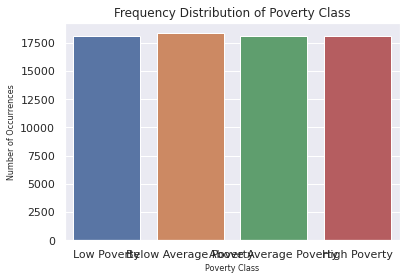

In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
povertyClass_count = data2015['PovertyClass'].value_counts()
sns.set(style="darkgrid")
sns.barplot(povertyClass_count.index, povertyClass_count.values)
plt.title('Frequency Distribution of Poverty Class')
plt.ylabel('Number of Occurrences', fontsize=8)
plt.xlabel('Poverty Class', fontsize=8)
plt.show()

Here we can confirm that we are working with a balanced data set in terms of each factor level of the variable we are trying to classify contain about the same amount of observations.

Next we need to remove any unnecessary variables from our data set that we do not want to use in model building. 

We can remove Poverty because it is the continuous version of the variable we are trying to classify, *PovertyClass*. We can remove *TotalPop, Citizen, Men, Women,* and *Employed* because they are aggregate counts of the total population of that variable in the geographical line item. We want all of our population counts to be percentages so they are on the same scale for each geographical area. This makes sure that the population size of the geographical area does not skew the model. 

There are four income variables in our data set: *Income, IncomeErr, IncomePerCap* and *IncomePerCapErr*. These are all highly correlated variables to each, and are very similar so we only want to use one for our model. Therefore, we took out *Income, IncomeErr, and IncomePerCapErr*, leaving just *IncomePerCap* in our data set for model building. 

We removed any geographically identifying variables from our data set so that our models would not train on location. This allows our model to be potentially run on any geographical area regardless of size and location to predict the Poverty Class in that area. The specific geographically identifying variables we removed are *CensusTract, County,* and *State*. 

In [0]:
census = data2015.copy()

#Remove attributes that are not useful to us
#Remove aggregate count variables
del census['Poverty']
del census['TotalPop']
del census['Citizen']
del census['Men']
del census['Women']
del census['Employed']

#Remove income varaibles since we are using just IncomePerCap
del census['Income']
del census['IncomeErr']
del census['IncomePerCapErr']

#Remove geographically identifying varaibles
del census['State']
del census['County']
del census['CensusTract']

We now have our complete data set for model building. We can take a look at the top 5 records to make sure all of the attributes that are in the data set are what we expect. 

In [0]:
#View data set
census.head()

,Hispanic,White,Black,Native,Asian,Pacific,Other,CitizenPercent,IncomePerCap,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,PrivateWork,PublicWork,EmployedPercent,SelfEmployed,FamilyWork,Unemployment,PovertyClass
0,0.90,87.40,7.70,0.30,0.60,0.00,3.10,77.20,25713.00,8.40,34.70,17.00,21.30,11.90,15.20,90.20,4.80,0.00,0.50,2.30,2.10,25.00,77.10,18.30,48.40,4.60,0.00,5.40,Below Average Poverty
1,0.80,40.40,53.30,0.00,2.30,0.00,3.20,77.10,18021.00,40.30,22.30,24.70,21.50,9.40,22.00,86.30,13.10,0.00,0.00,0.70,0.00,23.40,77.00,16.90,34.90,6.10,0.00,13.30,High Poverty
2,0.00,74.50,18.60,0.50,1.40,0.30,4.70,78.70,20689.00,19.70,31.40,24.90,22.10,9.20,12.40,94.80,2.80,0.00,0.00,0.00,2.50,19.60,64.10,23.60,46.30,12.30,0.00,6.20,Below Average Poverty
3,10.50,82.80,3.70,1.60,0.00,0.00,1.40,74.70,24125.00,1.60,27.00,20.80,27.00,8.70,16.40,86.60,9.10,0.00,0.00,2.60,1.60,25.30,75.70,21.20,40.30,3.10,0.00,10.80,Low Poverty
4,0.70,68.50,24.80,0.00,3.80,0.00,2.20,71.20,27526.00,17.50,49.60,14.20,18.20,2.10,15.80,88.00,10.50,0.00,0.00,0.60,0.90,24.80,67.10,27.60,46.80,5.30,0.00,4.20,Below Average Poverty


### **1.2 Training and Testing Split**

We are tasked to create a logistic regression model and support vector machine model for the classification task involved with our dataset, which is to classify a geographical area as a certain poverty class: Low Poverty, Below Average Poverty, Above Average Poverty, or High Poverty.

To assess how well each model performs we need to use an 80/20 training/testing split. For model assessment we will be using 5-fold cross validation, therefore doing an 80/20 train/test split on our data. The code for the creation of these cross validated training/testing sets can be seen below. We use the StratifiedKFold cross validation method provided in the SK Learn Python Package.

In [0]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

# we want to predict the X and y data as follows:
if 'PovertyClass' in census:
    y = census['PovertyClass'].values # get the labels we want
    del census['PovertyClass'] # get rid of the class label
    X = census.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 5
num_instances = len(y)
#cv_object = ShuffleSplit(n_splits=num_cv_iterations, test_size  = 0.2, random_state = 42)
cv_object = StratifiedKFold(n_splits = num_cv_iterations, shuffle = True, random_state = 42)

print(cv_object)

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


### **1.3 Logistic Regression Model**

In building our logistic regression model we are focused on building a model that has a high accuracy. Because we are working with an ordinal dependent variable, we also want to pay special attention to the confusion matrix and make sure that wrong classifications are not happening two or more levels away from the correct classification. For example, with wrong High Poverty classification we want to make sure they are not classified Low Poverty or Below Average Poverty. We would rather have most wrong High Poverty classifications get pushed one factor level down to Above Average Poverty. This is a trend we will look for in the confusion matrix.

For our initial logistic regression model we are using the SK Learn LogisticRegression method with the following initial parameters: 

    Penalty: 'l2'
    C: 1.0
    class_weight: None
    solver: 'lbfgs'
    multi_class: 'multinomial'
    max_iter: 10000

Using these parameters we ran this Logistic Regression model on our 80/20 training/test split 5-fold cross validated data to obtain 10 accuracies and 10 confusion matrices. To analyze the performance of our model we output the average accuracy and average confusion matrix. To make sure there are no outliers in the accuracy due to random chance we output the minimum and maximum accuracy obtained in the 5-fold cross validation run. 

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix
import pylab as pl

#model.predict_log_proba(X_test[0:5])

# first we create a reusable logisitic regression object
#    here we can setup the object with different learning parameters and constants
model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver = 'lbfgs', multi_class = 'multinomial', max_iter=10000, random_state = 42) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
acc_total = 0
acc_min = 1
acc_max = 0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    model.fit(X_train,y_train)  # train object
    y_hat = model.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    acc_total = acc_total + acc
    if acc < acc_min:
      acc_min = acc
    if acc > acc_max:
      acc_max = acc  

    conf = pd.crosstab(pd.Series(y_hat), pd.Series(y_test), rownames=['Predicted'], colnames=['Actual'], margins=True)
    if iter_num == 0:
      cm1 = conf
    if iter_num == 1:
      cm2 = conf
    if iter_num == 2:
      cm3 = conf
    if iter_num == 3:
      cm4 = conf
    if iter_num == 4:
      cm5 = conf

    print('Fold ',(iter_num+1), 'Complete')

    iter_num+=1

acc_average = acc_total / num_cv_iterations
print("The average accuracy for this",num_cv_iterations,"- fold, stratified cross validation logistic regression model is:",round((acc_average*100),2),"%")
print("The minimum accuracy for this",num_cv_iterations,"- fold, stratified cross validation logistic regression model is:",round((acc_min*100),2),"%")
print("The maximum accuracy for this",num_cv_iterations,"- fold, stratified cross validation logistic regression model is:",round((acc_max*100),2),"%")
print("")

print("The average confusion matrix for this",num_cv_iterations,"- fold, stratified cross validation logistic regression model is:")
cm_concat = pd.concat((cm1, cm2, cm3, cm4, cm5))
cm_group = cm_concat.groupby(cm_concat.index)
cm_group.mean()

Fold  1 Complete
Fold  2 Complete
Fold  3 Complete
Fold  4 Complete
Fold  5 Complete
The average accuracy for this 5 - fold, stratified cross validation logistic regression model is: 77.67 %
The minimum accuracy for this 5 - fold, stratified cross validation logistic regression model is: 77.36 %
The maximum accuracy for this 5 - fold, stratified cross validation logistic regression model is: 77.99 %

The average confusion matrix for this 5 - fold, stratified cross validation logistic regression model is:


Actual,Low Poverty,Below Average Poverty,Above Average Poverty,High Poverty,All
Predicted,,,,,
Above Average Poverty,10.60,567.20,2628.40,428.60,3634.80
All,3624.40,3668.20,3619.20,3622.40,14534.20
Below Average Poverty,562.60,2460.60,572.20,33.40,3628.80
High Poverty,3.40,10.20,369.00,3151.40,3534.00
Low Poverty,3047.80,630.20,49.60,9.00,3736.60


From this our initial logistic regression model obtained a 77.67% accuracy. Looking at the confusion matrix that our predicted wrong classifications are happening mostly one level away from the actual correct classification. For example with High Poverty, almost all of the misclassified High Poverty observations occurred just one level away as Above Average Poverty (369) with just a few misclassified High Poverty observations being classified as Below Average Poverty (10.2) or Low Poverty (3.4). As we are working with an ordinal dependent variable this is what we want to happen and helps forgive the underwhelming accuracy.  

The next piece is to look at the weights from the logistic regression model. We actually get four sets of weights because we have four factor levels for our variable we are classifying. Therefore, to make sure we are looking at the right sets of weights for each Poverty Class we need to know the order of the classes. We can get this easily by running model.classes_.

In [0]:
model.classes_

array(['Above Average Poverty', 'Below Average Poverty', 'High Poverty',
       'Low Poverty'], dtype=object)

Therefore, the order of our Poverty Classes is:

coef[0] = Above Average Poverty

coef[1] = Below Average Poverty

coef[2] = High Poverty

coef[3] = Low Poverty


The code below gets us the weights for the Above Average Poverty class:

In [0]:
weights = model.coef_.T # take transpose to make a column vector
variable_names = census.columns

print("Below are the weights from our intial logistic regression model:")

for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

Below are the weights from our intial logistic regression model:
Hispanic has weight of 0.005514890649479676
White has weight of -0.0036498849157799197
Black has weight of 0.0028607317409241697
Native has weight of 0.0041064238200003685
Asian has weight of 0.00021959334209518692
Pacific has weight of 0.001170242196469962
Other has weight of -4.579633289794888e-05
CitizenPercent has weight of 0.02424802546728693
IncomePerCap has weight of -1.0316361783165752e-05
ChildPoverty has weight of 0.12980454990823115
Professional has weight of 0.005942444405269377
Service has weight of 0.011869063338631393
Office has weight of -0.010047694839623283
Construction has weight of -0.0010929924936641554
Production has weight of 0.0034554398178353865
Drive has weight of -0.017512046771873343
Carpool has weight of 0.005908846075573107
Transit has weight of 0.004337336003034808
Walk has weight of 0.015088839028428882
OtherTransp has weight of 0.007789604242473596
WorkAtHome has weight of -0.0054537201803

We can visually see the weights for each attribute in our model in the plot below:

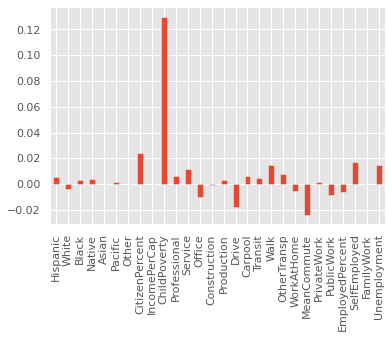

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(model.coef_[0],index=census.columns)
weights.plot(kind='bar')
plt.show()

The big issue is that these weights are not interpretable because not all of our data is on the same scale. All of our attributes are percentages 0-100 except for *IncomePerCap* and *MeanCommute*. Therefore, we need to get all of our data on the same scale. We can do this using the SK Learn Standard Scaler. The code to scale our data is below:

In [0]:
from sklearn.preprocessing import StandardScaler
# Scale the data
ss = StandardScaler()
X = ss.fit_transform(X)

Now that are data is on the same scale we can run our logistic regression model again. We do not expect a big change to the accuracy or confusion matrix, but we do expect to see a change to the weights. 

In [0]:
iter_num=0
acc_total = 0
acc_min = 1
acc_max = 0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    model.fit(X_train,y_train)  # train object
    y_hat = model.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    acc_total = acc_total + acc
    if acc < acc_min:
      acc_min = acc
    if acc > acc_max:
      acc_max = acc  

    conf = pd.crosstab(pd.Series(y_hat), pd.Series(y_test), rownames=['Predicted'], colnames=['Actual'], margins=True)
    if iter_num == 0:
      cm1 = conf
    if iter_num == 1:
      cm2 = conf
    if iter_num == 2:
      cm3 = conf
    if iter_num == 3:
      cm4 = conf
    if iter_num == 4:
      cm5 = conf

    print('Fold ',(iter_num+1), 'Complete')

    iter_num+=1

acc_average = acc_total / num_cv_iterations
print("The average accuracy for this",num_cv_iterations,"- fold, stratified cross validation logistic regression model is:",round((acc_average*100),2),"%")
print("The minimum accuracy for this",num_cv_iterations,"- fold, stratified cross validation logistic regression model is:",round((acc_min*100),2),"%")
print("The maximum accuracy for this",num_cv_iterations,"- fold, stratified cross validation logistic regression model is:",round((acc_max*100),2),"%")
print("")

print("The average confusion matrix for this",num_cv_iterations,"- fold, stratified cross validation logistic regression model is:")
cm_concat = pd.concat((cm1, cm2, cm3, cm4, cm5))
cm_group = cm_concat.groupby(cm_concat.index)
cm_group.mean()

Fold  1 Complete
Fold  2 Complete
Fold  3 Complete
Fold  4 Complete
Fold  5 Complete
The average accuracy for this 5 - fold, stratified cross validation logistic regression model is: 77.81 %
The minimum accuracy for this 5 - fold, stratified cross validation logistic regression model is: 77.45 %
The maximum accuracy for this 5 - fold, stratified cross validation logistic regression model is: 78.32 %

The average confusion matrix for this 5 - fold, stratified cross validation logistic regression model is:


Actual,Low Poverty,Below Average Poverty,Above Average Poverty,High Poverty,All
Predicted,,,,,
Above Average Poverty,10.40,563.60,2628.60,430.80,3633.40
All,3624.40,3668.20,3619.20,3622.40,14534.20
Below Average Poverty,559.60,2476.00,576.80,30.40,3642.80
High Poverty,2.60,9.00,368.00,3153.00,3532.60
Low Poverty,3051.80,619.60,45.80,8.20,3725.40


Just as we expected there is not a significant change to the accuracy or confusion matrix. Now we can look at the weights for scaled data for the Above Average Poverty class:

In [0]:
weights = model.coef_.T # take transpose to make a column vector
variable_names = census.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

Hispanic has weight of 0.10271335301757359
White has weight of -0.11515163752031003
Black has weight of 0.04352648018847576
Native has weight of 0.0927202196668209
Asian has weight of -0.015218410879576682
Pacific has weight of 0.0042884757482039
Other has weight of -0.021898589752734555
CitizenPercent has weight of 0.2672575230404903
IncomePerCap has weight of -0.16498486115498232
ChildPoverty has weight of 2.5016411379104673
Professional has weight of -0.02691291408303466
Service has weight of 0.006126698953790565
Office has weight of -0.11018365432832675
Construction has weight of -0.04137743602900352
Production has weight of -0.05625036741087244
Drive has weight of -0.1817263820708403
Carpool has weight of 0.050224766520798804
Transit has weight of 0.04098583520533721
Walk has weight of 0.1993614365945137
OtherTransp has weight of 0.12873994802574384
WorkAtHome has weight of -0.08086963086694567
MeanCommute has weight of -0.12840496138514482
PrivateWork has weight of -0.32902782808

We can visually see the weights for each attribute in our model in the plot below:

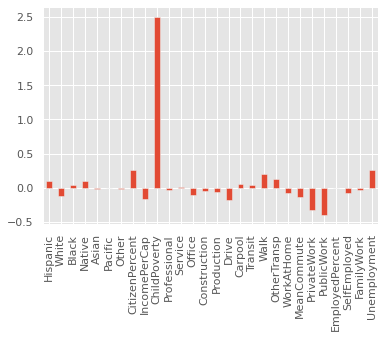

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(model.coef_[0],index=census.columns)
weights.plot(kind='bar')
plt.show()

We will discuss the interpretation of these weights from our Logistic Regression Model in Section 3 of this report. 

----------------------------------------------------------------------------------------

#### **1.3.1 PCA for Logistic Regression**

As our features are almost all percentages of a population of a census tract and we know that several of our variables can be grouped and in a way complement one another. There is good evidence we could have some multicollinearity in our features that affect our predictions. One example includes racial categories, where a large population of one racial makeup would effect the size of the other groups. 

Principal Component Analysis(PCA) could reduce this issue of multicollinearity in our data and potentially increase our accuracy.


However after testing, PCA produces accuracy of about 72% as shown below. Using principal components in lieu of the features at hand reduces accuracy.

In [0]:
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit 


cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
n_components = 25

pca = PCA(n_components=n_components, svd_solver='randomized')
#Ran locally with up to 5000 iterations, same convergence warnings appeared without and accuracy was similar
iterations = 500
log_sgd = SGDClassifier(fit_intercept=True, learning_rate='optimal', 
                        loss='log',   max_iter=iterations, n_jobs=-1, penalty='l2')


for train_idx, test_idx in cv_object.split(X,y):
    log_sgd.fit(pca.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(pca.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.742139662882697


We got an accuracy of 72%. This is lower than our original logisitc regression accuracy. It seems as though we did not have major issues with colinearity that PCA could adjust for. Therefore we did not use PCA in our Logistic Regression Model.

### **1.4 Support Vector Machine Model**

Building SVM model and checking accuracy.

In [0]:

from sklearn.svm import SVC

# train the model just as before
svm = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto') # get object
svm.fit(X_train, y_train)  # train object

y_hat = svm.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.7942066877666162
[[2702  560  328   29]
 [ 517 2533   11  607]
 [ 381   15 3218    8]
 [  15  515    5 3090]]


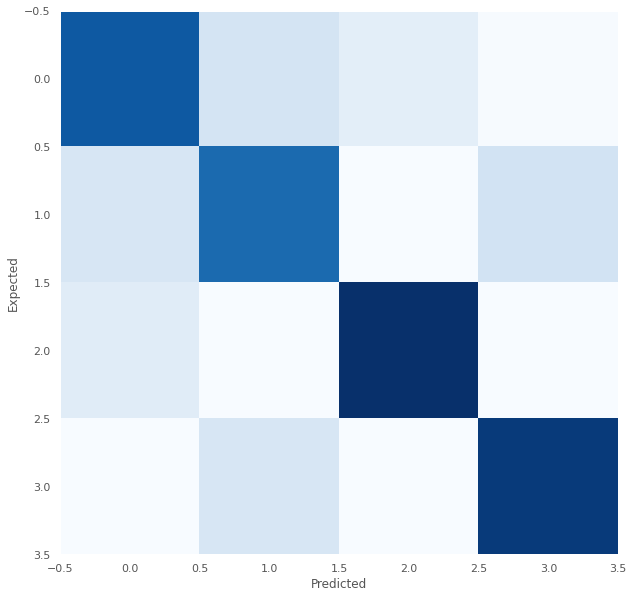

In [0]:
# Create a confusion matrix to see what classes StrandSliceClassifier is getting wrong 
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt



plt.subplots(figsize=(10, 10))
cm = confusion_matrix(y_true=y_test, y_pred=y_hat)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized,cmap=plt.get_cmap('Blues'),aspect='auto')
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.grid(False)

## **2. Advantages of Each Model**

Between our SVM and Logistic Regression model, our main measure of success for this classification problem, accuracy was similar. Logisitc Regression regularly scored around 77% accuracy whereas our SVM acheived almost 80% accuracy. In addition, there was more variance in the accuracy attained through logisitc regression than in the accuracy of SVM. We can expect 


First, speed of model building. Both SVM and Logistic Regression models are not instantaneously built in our environments. After several iterations and tests we found generally that SVM training several minutes longer than the Logisitc Regression model building. This speed diffrence could become even more pronounced if we were dealing with a larger data set. And is already an issue during the model building as multiple iterations of model building were necessary for this report. Logistic Regression has the advantage of speed over a SVM.

Given our needs to run this model multiple times to build the report with a strong difference of speed and our difference in accuracy remaining somewhat small, we can find good reason to focus on a logistic regression model if necessary moving forward.



## **3. Interpretation of Feature Weights**


In our logistic regression model our weights correspond to each of our four classes. For each class, the weights determine a calculated score of log odds for a tested instance to belong to that class. The odds of each class are compared and the strongest odds class score will then become the classification for that instance. 

To understand our feature importance we need to discuss our features in relation to each of our classes as we do below. For each variable we will graph the true weights that are applied for each class in our model and a normalized list of weights to more clearly see the weights in relation to one another. We found often some of the weights were such small numbers that listing them obscured the information, the normalization allows us to more clearly see the relationship features have most clearly when those features have an otherwise small impact. The non-normalized weights occur in each graph shown for each class. 

Each iteration of building the model resulted in different weights due to different train test splits when a specified seed was not set. While the sections below are exploring some of those nuanced relationships that may be model specific there are a few constants we found of important features that continued to affect the result with each iteration. 

First and foremost child poverty often showed up as a strong predictor of class at any class level. While child poverty certainly did not have a consistent and one for one relationship with poverty level, it definitely gives us valuable information for determining poverty class. Child Poverty is consistently one of the most important features for determining class and a major indicator of poverty overall. We are running our model with the assumption we do have access to child poverty levels in our attempt to predict poverty classification. 

We found economic indicators as a whole, whether through income, job type or unemployment rates were also common features that were strongly predictive of feature class, which of these specific variables could be the most effective in a given model could change with the train test split we had available. 

Racial data, often including citizen percent was also another group of variables that often had some weighting on poverty class, although it falls below economic indicators in importance quite often.  



In [0]:
# Set up for plots
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
variable_names = census.columns

from sklearn.preprocessing import normalize

std_weight = normalize(model.coef_.T)


To understand more of how our classifications are made we can extract a few predictions with the underlying predictive probabilities. For each instnace we classify, we have predictive probabilities calculated for each of our four classes. These are derived by the model from our weights and the calculations required to represent the logged odds as probabilities. 

Once these caluclations are made we can see the simple decision choice relies on the most likely class probability. For example, for our first instance, it was classified as high poverty, with a probability of high poverty at .725. As discussed earlier, while we are not measuring for error only one poverty class away we are more confident in our model seeing that most misclassifications occur within one poverty class away from the true classificaton. In the instances below, the next most likely classes are nearly always the adjacent poverty classes. Thefore we are extremely unlikely to misclassify low poverty as high poverty and vice versa. 

In [0]:
pred_temp = model.predict(X_test[0:5])

pred_proba = model.predict_proba(X_test[0:5])
#print(pred_proba)

log_proba = model.predict_log_proba(X_test[0:5])
for probs, label in zip(pred_proba,pred_temp):
    print("Classified as ",label, ". \nWith probabilities of ", round(probs[3],3), 
          "for low poverty.", round(probs[1],3), "for below average poverty.",
         round(probs[0],3), "for above average poverty.\n And ", round(probs[2],3), "for high poverty")
    print("\n")


Classified as  High Poverty . 
With probabilities of  0.0 for low poverty. 0.001 for below average poverty. 0.267 for above average poverty.
 And  0.732 for high poverty


Classified as  Above Average Poverty . 
With probabilities of  0.004 for low poverty. 0.411 for below average poverty. 0.572 for above average poverty.
 And  0.013 for high poverty


Classified as  Above Average Poverty . 
With probabilities of  0.002 for low poverty. 0.432 for below average poverty. 0.556 for above average poverty.
 And  0.011 for high poverty


Classified as  Below Average Poverty . 
With probabilities of  0.214 for low poverty. 0.726 for below average poverty. 0.06 for above average poverty.
 And  0.0 for high poverty


Classified as  Above Average Poverty . 
With probabilities of  0.0 for low poverty. 0.01 for below average poverty. 0.757 for above average poverty.
 And  0.234 for high poverty




###3.1 Low Poverty
Below we can see the plotted weights for our first class, Low Poverty	and the normalized weights for each variable listed. At only a first look there is clear indication that one variable is the most important feature for classifying a tract as high poverty and that is Child Poverty. On the surface this makes sense that we expect child poverty to correlate well with total poverty, however from exploration we know this relationship is not one for one and we cannot discount other variables. It is worth noting among all of our classes that child poverty features as an important feature. 


Income per capita seems to be a strong indicator of low poverty class. This seems a clear point of average income levels affacting overall poverty, as income increases, we are more likely to classify as low poverty.  




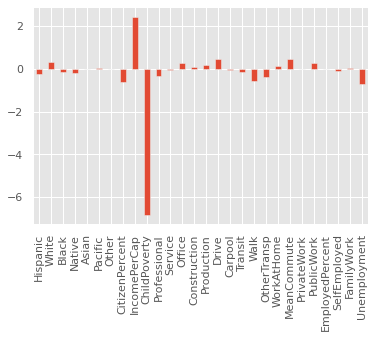

Hispanic has normalized weight of -0.2359
White has normalized weight of 0.3145
Black has normalized weight of -0.1435
Native has normalized weight of -0.2197
Asian has normalized weight of -0.0189
Pacific has normalized weight of 0.0206
Other has normalized weight of 0.0048
CitizenPercent has normalized weight of -0.6056
IncomePerCap has normalized weight of 2.4224
ChildPoverty has normalized weight of -6.815
Professional has normalized weight of -0.3436
Service has normalized weight of -0.056
Office has normalized weight of 0.2624
Construction has normalized weight of 0.0787
Production has normalized weight of 0.1748
Drive has normalized weight of 0.46
Carpool has normalized weight of -0.0697
Transit has normalized weight of -0.1542
Walk has normalized weight of -0.5784
OtherTransp has normalized weight of -0.3717
WorkAtHome has normalized weight of 0.1162
MeanCommute has normalized weight of 0.4422
PrivateWork has normalized weight of 0.0081
PublicWork has normalized weight of 0.281

In [0]:

#Weights Set One
weights = pd.Series(model.coef_[3],index=census.columns)
weights.plot(kind='bar')
plt.show()
for coef, name in zip(model.coef_.T,variable_names):
    print(name, 'has normalized weight of', round(coef[3],4))

###3.2 Below Average Poverty

Like low poverty, the child poverty feature is one of the most important features for classifying an instance as below average poverty. However there are several other variables that have similar measures of importance for this class. 

Again income per capita is a large feature and even more prominent than child poverty and more so than in low poverty situations. Below average poverty can be highly dependent on changes in per capita income.

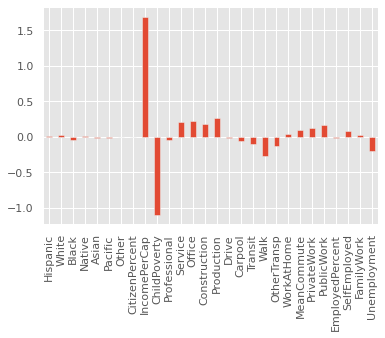

Hispanic has normalized weight of 0.007
White has normalized weight of 0.0269
Black has normalized weight of -0.0445
Native has normalized weight of 0.0177
Asian has normalized weight of -0.0102
Pacific has normalized weight of -0.0107
Other has normalized weight of 0.0009
CitizenPercent has normalized weight of 0.004
IncomePerCap has normalized weight of 1.6905
ChildPoverty has normalized weight of -1.0933
Professional has normalized weight of -0.0505
Service has normalized weight of 0.2094
Office has normalized weight of 0.2222
Construction has normalized weight of 0.1809
Production has normalized weight of 0.2724
Drive has normalized weight of -0.021
Carpool has normalized weight of -0.0625
Transit has normalized weight of -0.1045
Walk has normalized weight of -0.267
OtherTransp has normalized weight of -0.1284
WorkAtHome has normalized weight of 0.042
MeanCommute has normalized weight of 0.0954
PrivateWork has normalized weight of 0.1261
PublicWork has normalized weight of 0.1637
E

In [0]:
#Weights Set Two
weights = pd.Series(model.coef_[1],index=census.columns)
weights.plot(kind='bar')
plt.show()
for coef, name in zip(model.coef_.T,variable_names):
    print(name, 'has normalized weight of', round(coef[1],4))

###3.3 Above Average Poverty

Whereas Child poverty in low poverty and below average classifications had a negative association with classifying, above average has a strong positive strength associated with the child poverty variable. Again child poverty is much stronger than other available features. 

However when classifying there are another few features that show as important. Some methods of working such as proportions of private and public work can negatively impact the odds of classifying as above average poverty. Finally citizen percent is a variable that continues to show up as an indicator that when citizen percentage changes in a tract, all else being equal, higher citizen counts indicate lower levels of poverty. 


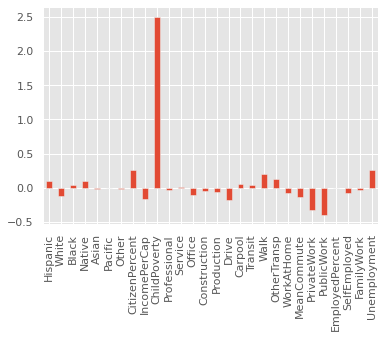

Hispanic has normalized weight of 0.1027
White has normalized weight of -0.1152
Black has normalized weight of 0.0435
Native has normalized weight of 0.0927
Asian has normalized weight of -0.0152
Pacific has normalized weight of 0.0043
Other has normalized weight of -0.0219
CitizenPercent has normalized weight of 0.2673
IncomePerCap has normalized weight of -0.165
ChildPoverty has normalized weight of 2.5016
Professional has normalized weight of -0.0269
Service has normalized weight of 0.0061
Office has normalized weight of -0.1102
Construction has normalized weight of -0.0414
Production has normalized weight of -0.0563
Drive has normalized weight of -0.1817
Carpool has normalized weight of 0.0502
Transit has normalized weight of 0.041
Walk has normalized weight of 0.1994
OtherTransp has normalized weight of 0.1287
WorkAtHome has normalized weight of -0.0809
MeanCommute has normalized weight of -0.1284
PrivateWork has normalized weight of -0.329
PublicWork has normalized weight of -0.3

In [0]:
#Weights Set Three
weights = pd.Series(model.coef_[0],index=census.columns)
weights.plot(kind='bar')
plt.show()
for coef, name in zip(model.coef_.T,variable_names):
    print(name, 'has normalized weight of', round(coef[0],4))

###3.4 High Poverty


Like above average poverty there are a few strong variables dwarfed by child poverty that indicate our poverty class level. Similar to low poverty we see child poverty is an overwhelmingly important variable. 

Per capita income is once again a strong variable indicative of poverty, whereas it was positively correlated strongly with low poverty before, it is here strongly negatively correlated with high poverty classifications. 



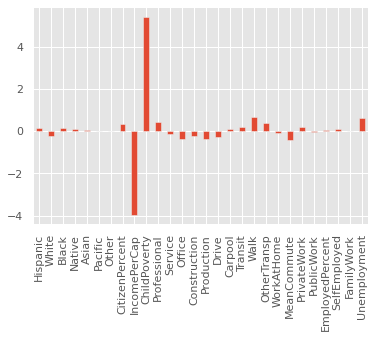

Hispanic has normalized weight of 0.1261
White has normalized weight of -0.2263
Black has normalized weight of 0.1445
Native has normalized weight of 0.1093
Asian has normalized weight of 0.0443
Pacific has normalized weight of -0.0142
Other has normalized weight of 0.0161
CitizenPercent has normalized weight of 0.3344
IncomePerCap has normalized weight of -3.9479
ChildPoverty has normalized weight of 5.4067
Professional has normalized weight of 0.421
Service has normalized weight of -0.1595
Office has normalized weight of -0.3744
Construction has normalized weight of -0.2182
Production has normalized weight of -0.3909
Drive has normalized weight of -0.2573
Carpool has normalized weight of 0.082
Transit has normalized weight of 0.2177
Walk has normalized weight of 0.6461
OtherTransp has normalized weight of 0.3714
WorkAtHome has normalized weight of -0.0774
MeanCommute has normalized weight of -0.4091
PrivateWork has normalized weight of 0.1948
PublicWork has normalized weight of -0.05

In [0]:
#Weights Set Four
weights = pd.Series(model.coef_[2],index=census.columns)
weights.plot(kind='bar')
plt.show()
for coef, name in zip(model.coef_.T,variable_names):
    print(name, 'has normalized weight of', round(coef[2],4))

## **4. Chosen Support Vector Insight**

The plots below show us what the original statistics of the data looked like compared to the statistics of the support vectors. In the examples below the separation of the support vectors is not as large as the separation we see in the original data because the support vectors are instances closest to the class boundaries or incorrectly classified instances in the training set. The graphs below represent a subset of the variables used in the model. The chosen variables had the largest separation in the original data and were the best to graph.

In [0]:
#Prepare Data for graphing 
df_tested_on = X_train.copy()
#df_support = df_tested_on.[svm.support_,:].copy()

df_tested_on = pd.DataFrame(df_tested_on)

df_tested_on.columns = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific', 'Other',
       'CitizenPercent', 'IncomePerCap', 'ChildPoverty', 'Professional',
       'Service', 'Office', 'Construction', 'Production', 'Drive', 'Carpool',
       'Transit', 'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute',
       'EmployedPercent', 'PrivateWork', 'PublicWork', 'SelfEmployed',
       'FamilyWork', 'Unemployment']

df_support = df_tested_on.iloc[svm.support_,:].copy()
df_support['PovertyClass'] = y[svm.support_]

df_original = census.copy()
df_original['PovertyClass'] = y

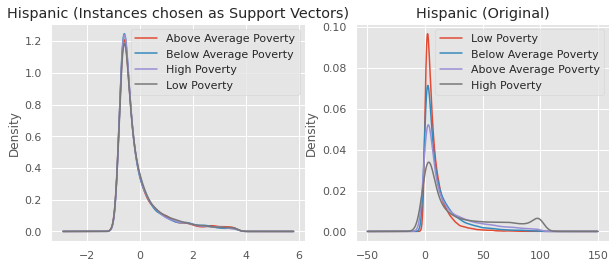

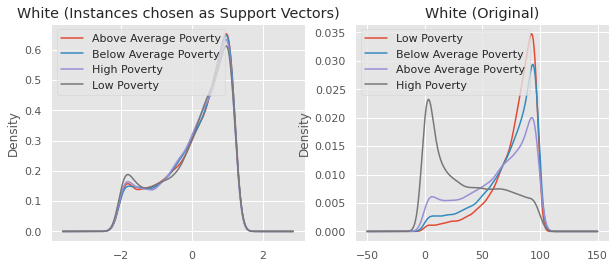

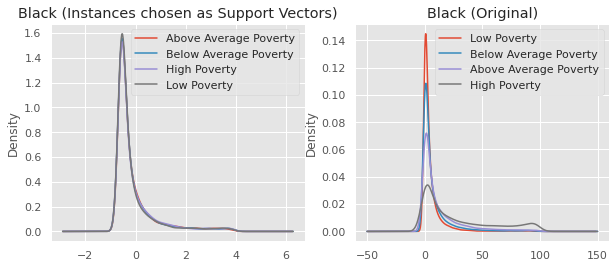

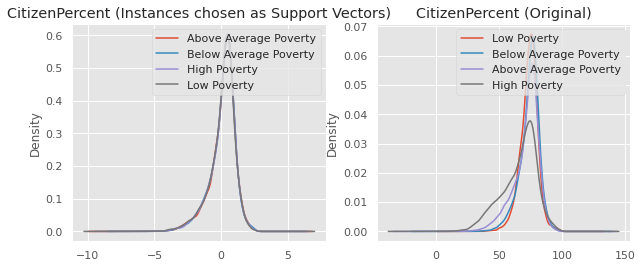

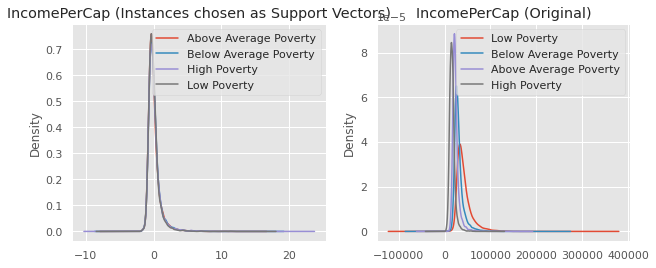

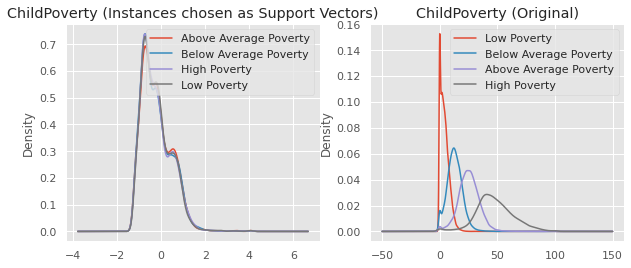

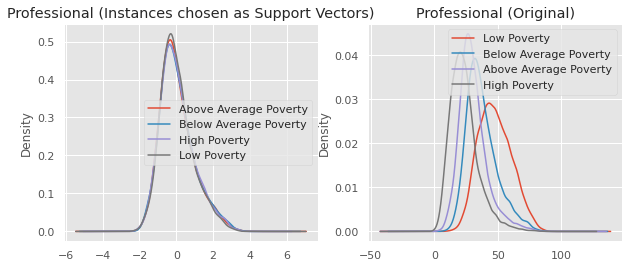

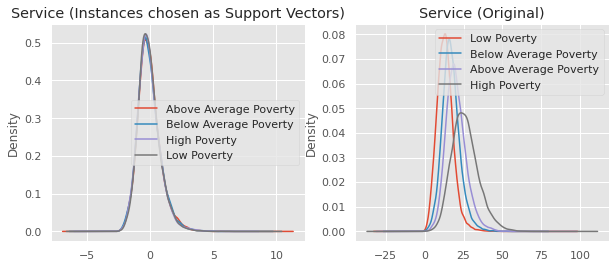

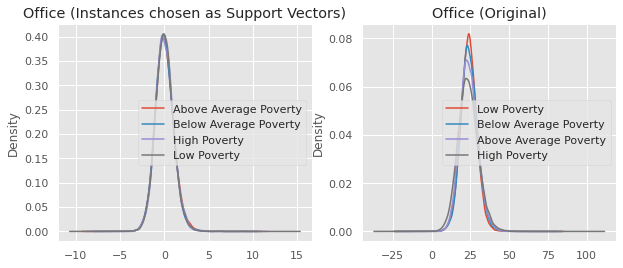

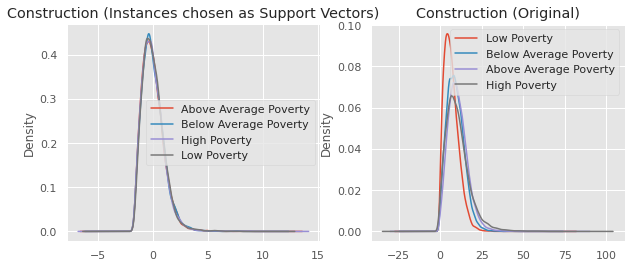

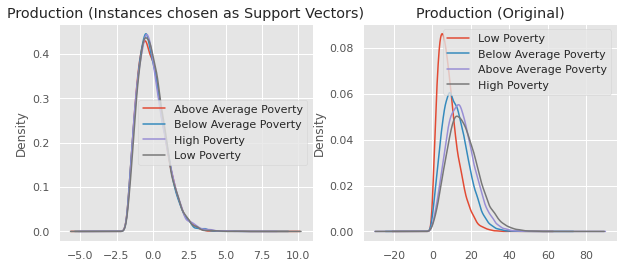

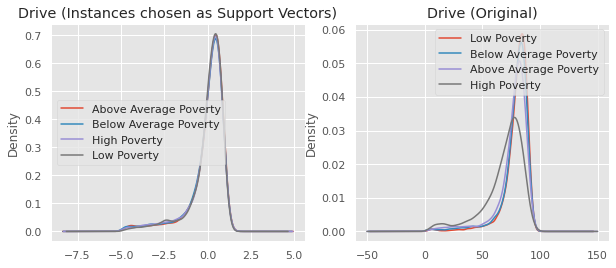

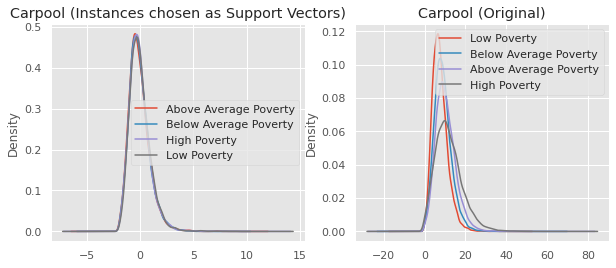

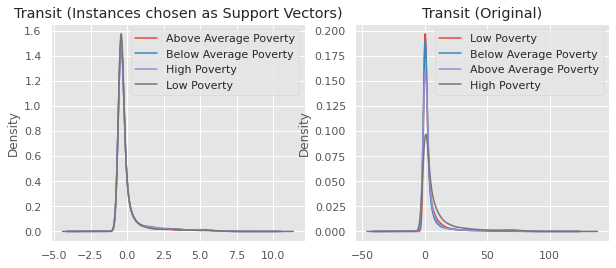

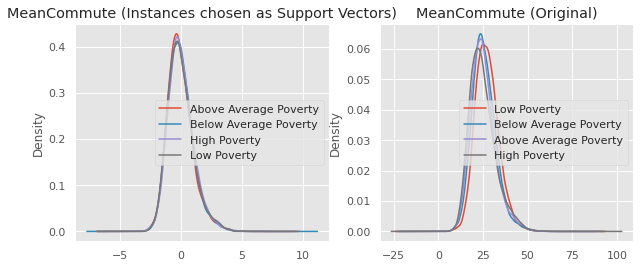

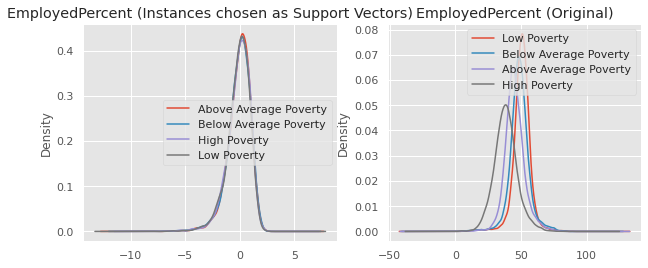

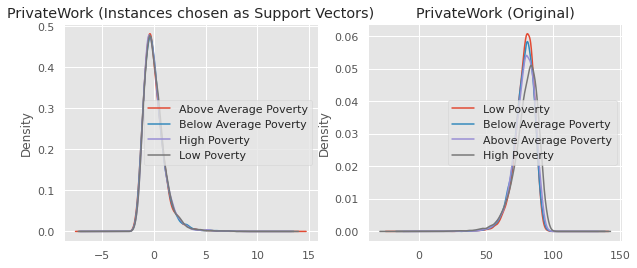

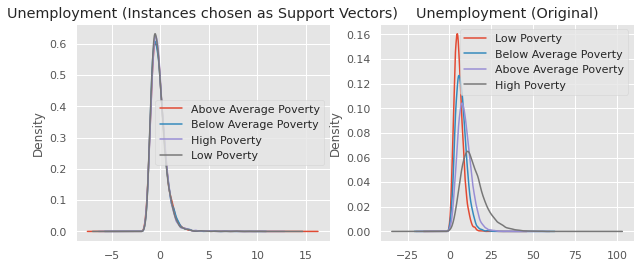

In [0]:
from pandas.plotting import boxplot

## group the original data and the support vectors
df_grouped_support = df_support.groupby(['PovertyClass'])
df_grouped = df_original.groupby(['PovertyClass'])

# variables to plot
vars_to_plot = ['Hispanic', 'White', 'Black','CitizenPercent', 'IncomePerCap', 'ChildPoverty', 'Professional','Service', 'Office', 'Construction', 'Production', 'Drive', 'Carpool','Transit', 'MeanCommute','EmployedPercent', 'PrivateWork', 'Unemployment']


for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(model.classes_)
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Low Poverty','Below Average Poverty','Above Average Poverty','High Poverty'])
    plt.title(v+' (Original)')